<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-исходных-данных" data-toc-modified-id="Описание-исходных-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание исходных данных</a></span></li><li><span><a href="#Подготовка-и-исследовательский-анализ-данных" data-toc-modified-id="Подготовка-и-исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка и исследовательский анализ данных</a></span></li><li><span><a href="#Подготовка-к-обучению-моделей" data-toc-modified-id="Подготовка-к-обучению-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к обучению моделей</a></span></li><li><span><a href="#Обучение-и-тестирование-моделей" data-toc-modified-id="Обучение-и-тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и тестирование моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общий-вывод-и-рекомендации-заказчику" data-toc-modified-id="Общий-вывод-и-рекомендации-заказчику-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод и рекомендации заказчику</a></span></li></ul></div>

# Исследование оттока клиентов телеком-компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание исходных данных

Заказчик предоставил данные в нескольких таблицах:

* **contract** - информация о договоре клиента;
* **personal** - персональная информация о клиенте;
* **internet** - информация об интернет-услугах;
* **phone** - информация об услугах телефонии.

Информация о договорах актуальна на дату последней записи 1 февраля 2020.

**contract:**

- _customerID:_ уникальный идентификатор клиента;
- _BeginDate:_ дата подключения к оператору;
- _EndDate:_ дата прекращения договора;
- _Type:_ тип договора (с помесячной оплатой, годовой или двухгодовой);
- _Paperlessbilling:_ электронный счет;
- _PaymentMethod:_ метод оплаты;
- _MonthlyCharges:_ ежемесячная плата за услуги;
- _TotalCharges:_ общая плата за услуги за все время.

**personal:**

- _customerID:_ уникальный идентификатор клиента;
- _Gender:_ пол клиента;
- _SeniorCitizen:_ является ли клиент пенсионером;
- _Partner:_ наличие супруга/супруги;
- _Dependents:_ наличие иждивенцев.

**internet:**

- _customerID:_ уникальный идентификатор клиента;
- _InternetService:_ тип подключения интернета (DSL, оптоволокно);
- _OnlineSecurity:_ наличие услуги блокировки небезопасных сайтов;
- _OnlineBackup:_ наличие облачного хранилища для создания резервных копий;
- _DeviceProtection:_ наличие услуги антивируса;
- _TechSupport:_ наличие выделенной линии технической поддержки;
- _StreamingTV:_ наличие услуги онлайн-телевидения;
- _StreamingMovies:_ наличие услуги онлайн-кинотеатра.

**phone:**

- _customerID:_ уникальный идентификатор клиента;
- _MultipleLines:_ наличие нескольких телефонных линий у клиента.


**Целевой признак:**

- _**contract['EndDate']**_ - уйдет клиент или нет.



## Подготовка и исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier



RANDOM_STATE = 42

pd.set_option('display.max_columns', None)

numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
categorial_columns = ['Type','PaymentMethod','gender','SeniorCitizen','InternetService']


alpha = 0.05

import warnings
from warnings import filterwarnings
warnings.filterwarnings('error')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [2]:
#функции используесые в работе
def df_analyz(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество уникальных пользователей:', len(df['customerID'].unique()))
    display(df.head(10))
    display(df.describe())
    df.info()
    
def one_zero(binar):  #функция, возвращающую 1 при признаке 'Yes' и 0 при признаке 'No'
    if binar == 'Yes':
        return 1
    elif binar == 'No':
        return 0    
def upsample(features, target, repeat):     
    features_zeros = features[target == 0]     
    features_ones = features[target == 1]     
    target_zeros = target[target == 0]     
    target_ones = target[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(         
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled    

In [3]:
try:  # local import
    df_contract = pd.read_csv(r'C:\\Users\\NEO\\Desktop\\DataSience\\ProjectsYP\\final_provider\\contract.csv')
    df_internet = pd.read_csv(r'C:\\Users\\NEO\\Desktop\\DataSience\\ProjectsYP\\final_provider\\internet.csv')
    df_personal = pd.read_csv(r'C:\\Users\\NEO\\Desktop\\DataSience\\ProjectsYP\\final_provider\\personal.csv')
    df_phone = pd.read_csv(r'C:\\Users\\NEO\\Desktop\\DataSience\\ProjectsYP\\final_provider\\phone.csv')

except:  # from Praktikum server
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
df_analyz(df_contract)

Количество стобцов: 8
Количество строк: 7043
Количество дубликатов: 0
Количество уникальных пользователей: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [6]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [7]:
df_contract['BeginDate'].max()

'2020-02-01'

In [8]:
df_contract['TotalCharges'].unique().min() #в столбце есть пробелы 

' '

**Выводы**:
* В данных нет пропусков
* `BeginDate` и `EndDate` надо перевести в формат даты 
* `No` в `EndDate` означает, что пользователь продолжает пользоваться услугами - это целевой признак равный 0
* После выделения целевого признака надо будет заменить `No` на `01.02.2020` в `EndDate`(дату последнего заполнения таблицы)
* `TotalCharges` надо перевести в числовой типб чем заполнить пробелы?
* В столбце `PaperlessBilling` с бинарными данными ('yes' и 'no') заменим данные на 1 и 0
* В столбцах `PaymentMethod`, `Type` надо применить One Hot Encoding

In [9]:
df_analyz(df_personal)

Количество стобцов: 5
Количество строк: 7043
Количество дубликатов: 0
Количество уникальных пользователей: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Выводы**:
* В данных нет пропусков
* В столбцах `Partner` и `Dependents` с бинарными данными ('yes' и 'no') заменим данные на 1 и 0
* В столбце `gender`  надо применить One Hot Encoding

In [10]:
df_analyz(df_internet)

Количество стобцов: 8
Количество строк: 5517
Количество дубликатов: 0
Количество уникальных пользователей: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2474-BRUCM,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

**Выводы**:
* В данных нет пропусков
* Данные есть не по всем клиентам
* В столбцах `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`  с бинарными данными ('yes' и 'no') заменим данные на 1 и 0

In [12]:
df_analyz(df_phone)

Количество стобцов: 2
Количество строк: 6361
Количество дубликатов: 0
Количество уникальных пользователей: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2474-BRUCM,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы**:
* В данных нет пропусков
* Данные есть не по всем клиентам
* В столбце `MultipleLines` с бинарными данными ('yes' и 'no') заменим данные на 1 и 0

**Вопросы**:
* Целевой признак - если `EndDate` равен `No`? 
* Какую метрику надо использовать? 
* На какие значения метрики надо ориентироваться? 
* Можно ли считать что отстутствие данных об услугах означает их неиспользование?
* Можно ли в столбцах с бинарными данными ('yes' и 'no') заменим данные на 1 и 0 напрямую, без использования OHE, чтобы
не создавать большое количество признаков, которые могут запутать модельи таким образом понизить размерность? 

Подготовим данные на основе выводов, полученных на предыдущих шагах

In [13]:
column_binar = ['PaperlessBilling', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
            'StreamingTV', 'StreamingMovies','MultipleLines']
table_list = [df_contract, df_personal, df_internet, df_phone]

In [14]:
for col in column_binar:
    for table in table_list:
        if col in table.columns:
            table[col] = table[col].apply(one_zero)

In [15]:
for table in table_list:
    display(table.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,1,Mailed check,53.85,108.15


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0


Добавим целевой признак Churn, который будет означать уход клиента
Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0.
Если дата ухода есть, то целевой признак равен 1.

In [16]:
df_contract['Churn'] = df_contract.apply(lambda x: 0 if x.EndDate == 'No' else 1, axis=1)


Заменим все значения "No" в `EndDate` на последнего заполнения датасета (01.02.2020) 

In [17]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])
print(df_contract[df_contract['EndDate'] == 'No'].shape[0])

0


Переведем `EndDate` и `BeginDate` в формат даты 

In [18]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')

В столбце TotalCharges есть пробелы посмотрим на них

In [19]:
df_contract.loc[df_contract.loc[:, 'TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,,0


Как видим, это все новые клиенты, подключившиеся 01.02.2020. Предположим что они еще не разу не платили за услуги. Логично заменить пробелы нулями.

In [20]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(' ', 0)
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])

Добавим новый столбец `TotalDays`, который будет означать, сколько пользователь пользовался услугами 

In [21]:
df_contract['TotalDays'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 550.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,61


Объединим все данные в один датафрейм 

In [22]:
df_churn = df_contract \
    .merge(df_personal, how='left', on='customerID') \
    .merge(df_internet, how='left', on='customerID') \
    .merge(df_phone, how='left', on='customerID') 

In [23]:
df_churn['customerID'].is_unique #Проверим, что все значения `customerID` уникальные 

True

In [24]:
#df_churn = df_churn.set_index('customerID') #Установим `customerID` в качестве индекса

In [25]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   int64         
 13  Dependents        7043 non-null   int64         
 14  InternetService   5517 n

In [26]:
df_churn.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,TotalDays,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,6361.000000
mean,0.592219,64.761692,2279.734304,0.265370,985.996166,0.162147,0.483033,0.299588,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197,0.467065
std,0.491457,30.090047,2266.794470,0.441561,747.587844,0.368612,0.499748,0.458110,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022,0.498953
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,0.000000,273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1394.550000,0.000000,883.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3786.600000,1.000000,1676.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Пропуски в `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` и `MultipleLines` скорее всего означают, что услуги не подключены. 
Заменим пропуски на **0**

In [27]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    df_churn[column] = df_churn[column].fillna(0)

In [28]:
df_churn.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,TotalDays,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.592219,64.761692,2279.734304,0.265370,985.996166,0.162147,0.483033,0.299588,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.421837
std,0.491457,30.090047,2266.794470,0.441561,747.587844,0.368612,0.499748,0.458110,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.493888
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,0.000000,273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1394.550000,0.000000,883.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3786.600000,1.000000,1676.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,1.000000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   int64         
 13  Dependents        7043 non-null   int64         
 14  InternetService   7043 n

**Данные подготовлены, теперь проведем их анализ.**

Посмотрим распределение значений для категориальных данных 

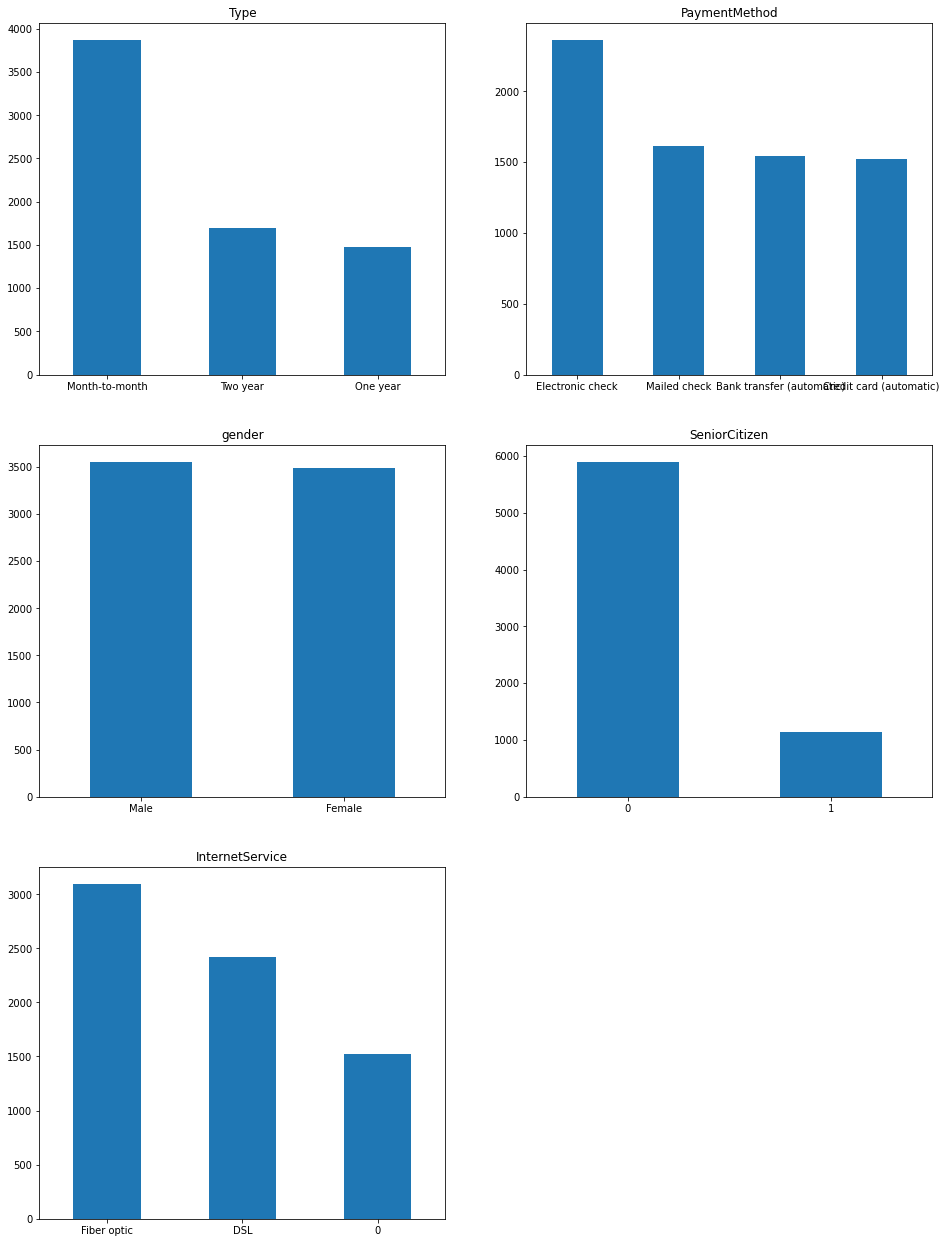

In [30]:
cols = 2
rows = 3

plt.figure(figsize=(16, 22))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    df_churn[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

Посмотрим, как влияют признаки на целевой признак - факт ухода клиента. Воспользуемся chi2_contingency для определения статистической значимости различий ушедших и оставшихся клиентов.

Для лаконичности создадим функцию, принимающую на вход столбец, по которому нужна группировка. Функция будет строить таблицу с количеством ушедших и оставшихся клиентов, сгруппированных по нужному признаку, вычислять значение статистики и делать вывод о влиянии признака на уход клиента из компании.

In [31]:
def table_for_chi2(col_group):
    table1 = df_churn.groupby(col_group, as_index=False)['Churn'].sum()
    table2 = df_churn.groupby(col_group, as_index=False)['customerID'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'customerID':'all'}, inplace = True)
    merge['notChurn'] = merge['all'] - merge['Churn']
    merge = merge.drop('all', axis=1)
        
    stat, p, dof, expected = chi2_contingency(merge[['Churn', 'notChurn']])
      
    return merge, p

Сформулируем гипотезу так:

* H0: признак не связан с оттоком клиентов;
* H1: признак связан с оттоком клиентов.

Примем значение порога статистической значимости alpha = 0.05.

Вызовем функцию для всех категориальных столбцов:

,Type,Churn,notChurn
0,Month-to-month,1655,2220
1,One year,166,1307
2,Two year,48,1647


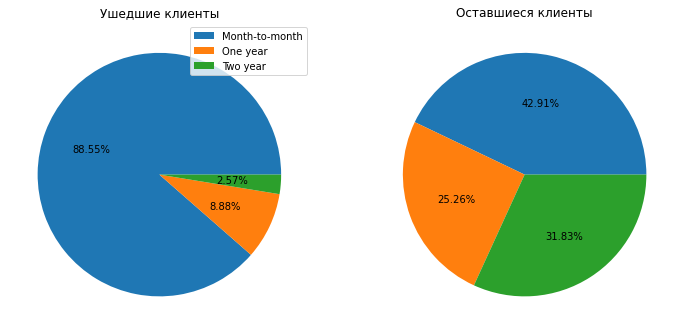

p-значение: 5.863038300672725e-258
Отклонить нулевую гипотезу


,PaperlessBilling,Churn,notChurn
0,0,469,2403
1,1,1400,2771


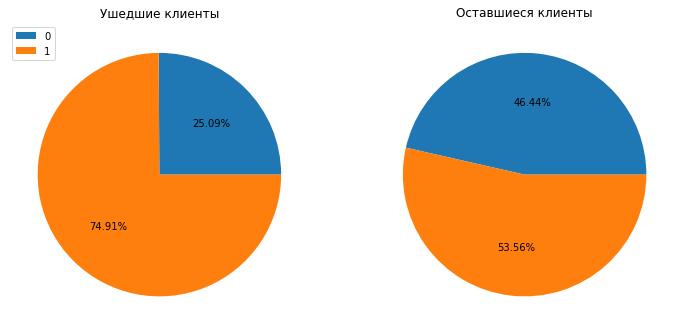

p-значение: 4.073354668665985e-58
Отклонить нулевую гипотезу


,PaymentMethod,Churn,notChurn
0,Bank transfer (automatic),258,1286
1,Credit card (automatic),232,1290
2,Electronic check,1071,1294
3,Mailed check,308,1304


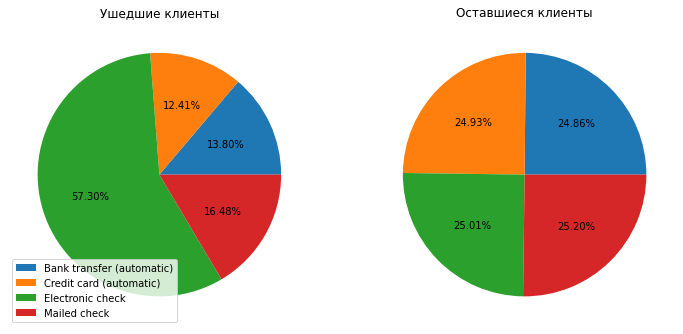

p-значение: 3.6823546520097993e-140
Отклонить нулевую гипотезу


,gender,Churn,notChurn
0,Female,939,2549
1,Male,930,2625


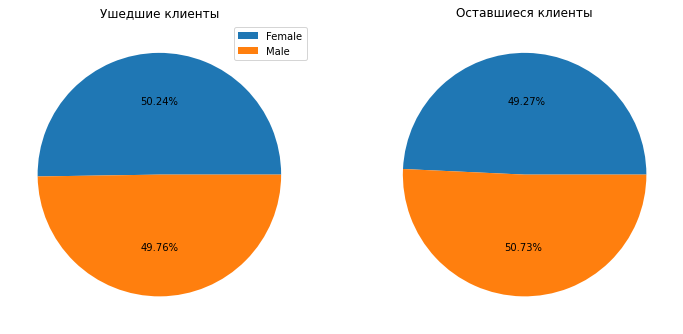

p-значение: 0.48657873605618596
Не получилось отклонить нулевую гипотезу


,SeniorCitizen,Churn,notChurn
0,0,1393,4508
1,1,476,666


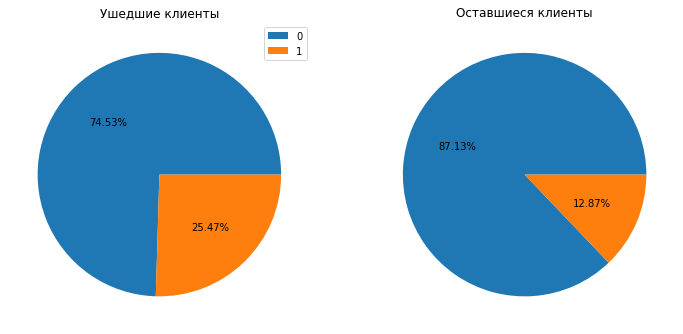

p-значение: 1.510066805092378e-36
Отклонить нулевую гипотезу


,Partner,Churn,notChurn
0,0,1200,2441
1,1,669,2733


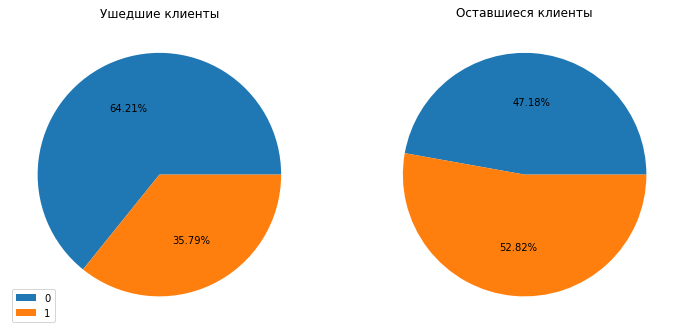

p-значение: 2.1399113440759935e-36
Отклонить нулевую гипотезу


,Dependents,Churn,notChurn
0,0,1543,3390
1,1,326,1784


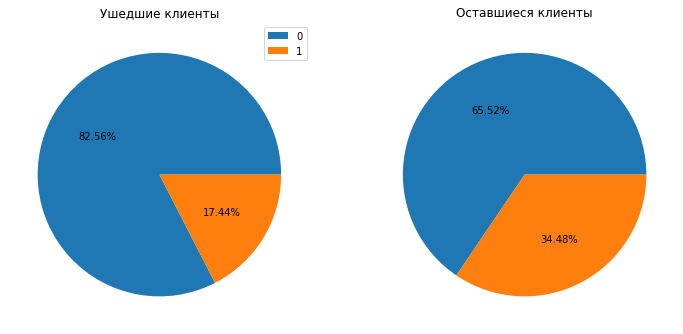

p-значение: 4.924921661215491e-43
Отклонить нулевую гипотезу


,InternetService,Churn,notChurn
0,0,113,1413
1,DSL,459,1962
2,Fiber optic,1297,1799


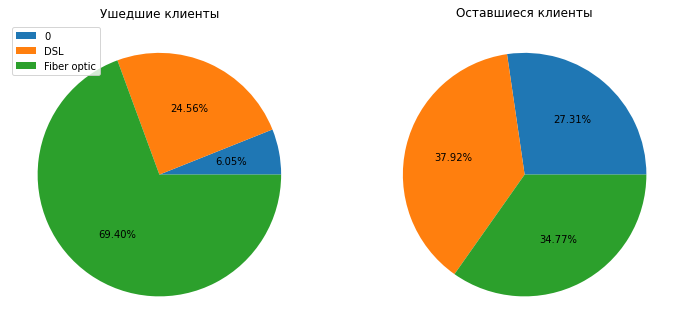

p-значение: 9.571788222840544e-160
Отклонить нулевую гипотезу


,OnlineSecurity,Churn,notChurn
0,0.0,1574,3450
1,1.0,295,1724


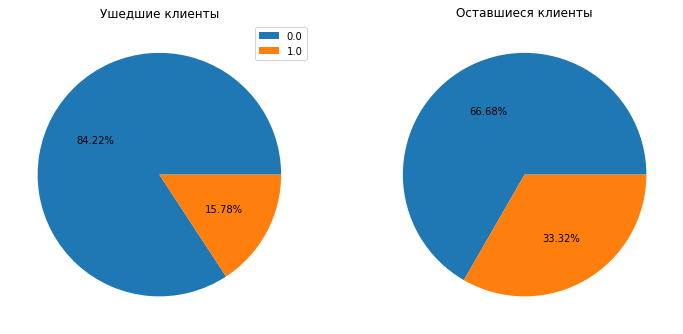

p-значение: 1.2320984831180024e-46
Отклонить нулевую гипотезу


,OnlineBackup,Churn,notChurn
0,0.0,1346,3268
1,1.0,523,1906


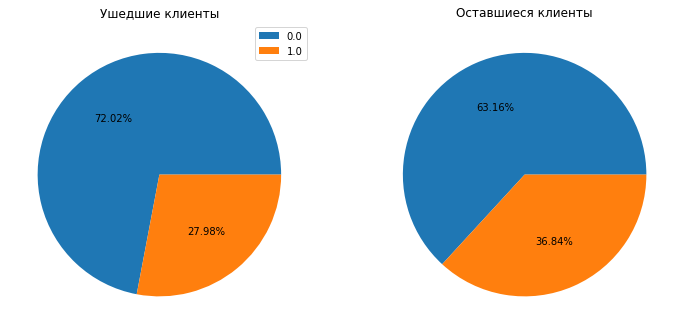

p-значение: 6.214092807254797e-12
Отклонить нулевую гипотезу


,DeviceProtection,Churn,notChurn
0,0.0,1324,3297
1,1.0,545,1877


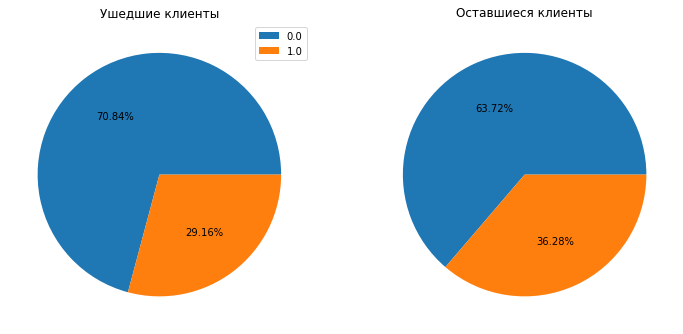

p-значение: 3.315693222362861e-08
Отклонить нулевую гипотезу


,TechSupport,Churn,notChurn
0,0.0,1559,3440
1,1.0,310,1734


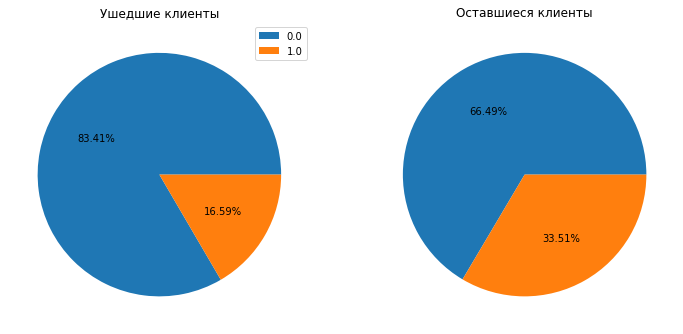

p-значение: 2.9235674453141176e-43
Отклонить нулевую гипотезу


,StreamingTV,Churn,notChurn
0,0.0,1055,3281
1,1.0,814,1893


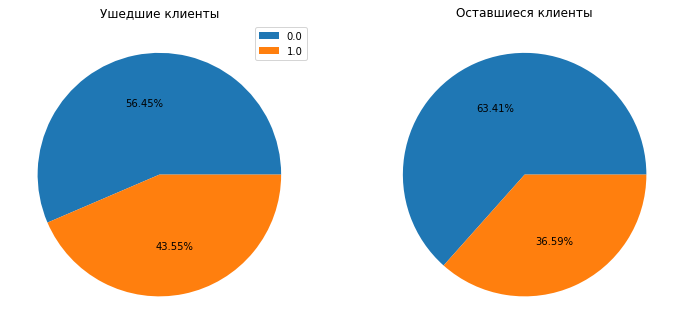

p-значение: 1.3024835736732676e-07
Отклонить нулевую гипотезу


,StreamingMovies,Churn,notChurn
0,0.0,1051,3260
1,1.0,818,1914


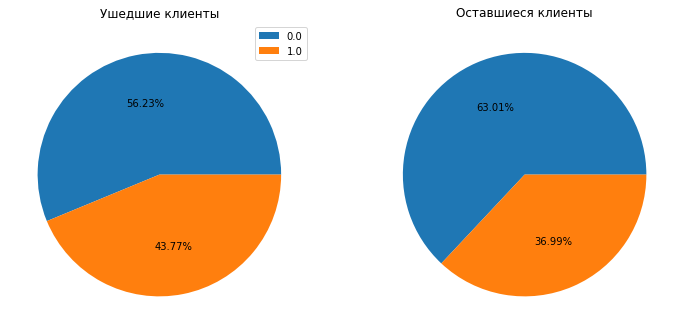

p-значение: 2.9974738476267514e-07
Отклонить нулевую гипотезу


,MultipleLines,Churn,notChurn
0,0.0,1019,3053
1,1.0,850,2121


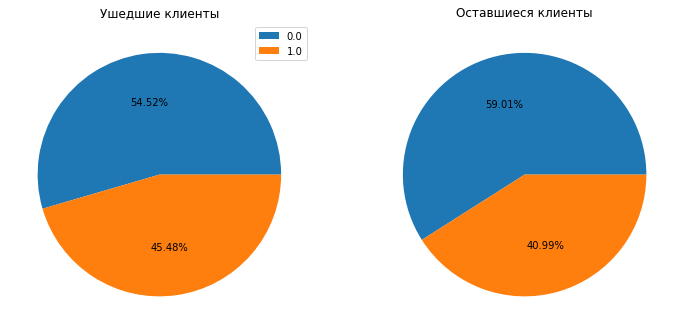

p-значение: 0.0008433795342472428
Отклонить нулевую гипотезу


In [32]:
categorials_columns = ['Type','PaperlessBilling','PaymentMethod','gender','SeniorCitizen','Partner','Dependents','InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in categorials_columns:
    table_chi2, p_chi2 = table_for_chi2(col)
    display(table_chi2)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.pie(table_chi2['Churn'], autopct='%1.2f%%')
    plt.legend(labels=table_chi2[col], loc='best')
    plt.title('Ушедшие клиенты')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(table_chi2['notChurn'], autopct='%1.2f%%')
    plt.title('Оставшиеся клиенты')
    plt.show()
    print('p-значение:', p_chi2)
    if p_chi2 < alpha:
        print('Отклонить нулевую гипотезу')
    else:
        print('Не получилось отклонить нулевую гипотезу')

Видно, что не получилось отклонить нулевую гипотезу только по признаку gender. Можем удалить его из датафрейма, так как он неинформативен. Все остальные признаки значимы.

**Выводы**:
* Самый популярный способ оплаты - помесячный 
* Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
* Самый частый способ подключения - оптоволокно
* Пенсионеров заключающих договора значительно меньше.
* Доля отказов среди тех, кто использует помесячную оплату выше, чем среди тех, кто сразу платит за 1/2 года 
* Дополнительные услуги слабо влияют на отказы
* Пенсионеры уходят чаще, но скорее всего не из-за качества услуг 
* Если пользователь не пользуется интернетом, то вероятность отказа ниже. Скорее всего это связано с тем, что более возрастные люди не хотят разбираться в том, как сменить поставщика услуг

Посмотрим распределение значений и диаграммы размаха для количественных данных

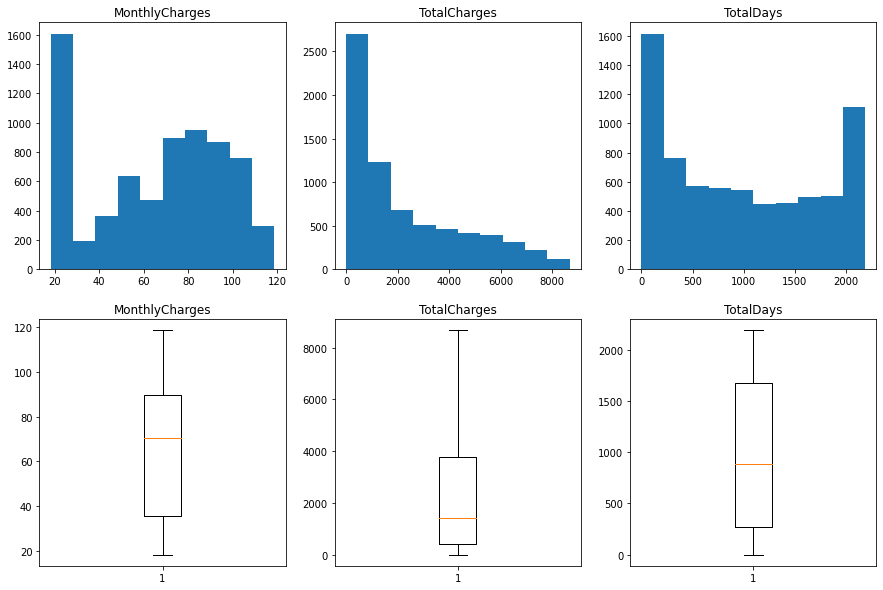

,MonthlyCharges,TotalCharges,TotalDays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


In [33]:

cols = 3
rows = 2

plt.figure(figsize=(15, 10))

idx = 0
for column in numeric_columns:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.hist(df_churn[column])
    plt.title(column)
    
for column in numeric_columns:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.boxplot(df_churn[column])
    plt.title(column)
        
plt.show()

display(df_churn[numeric_columns].describe())

Посмотрим поближе как распределены ежемесячные платежи и какие можно сделать из этого выводы

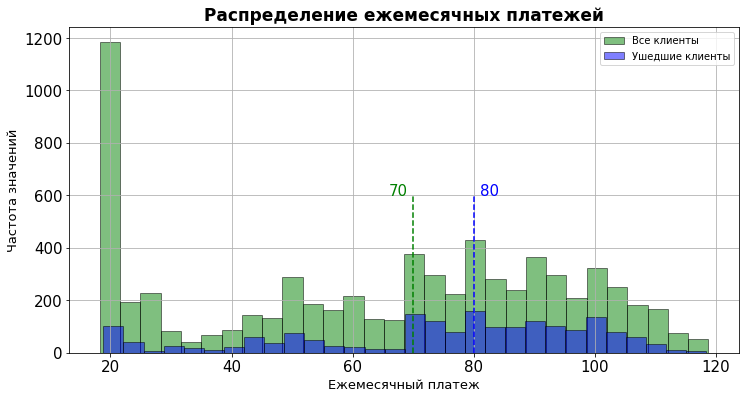

In [34]:
ax = df_churn.plot(kind='hist', y='MonthlyCharges', ec='black', bins=30, 
                              linewidth=1, alpha=0.5, label='Все клиенты', color='g')
df_churn[(df_churn['Churn']==1)].plot(kind='hist', y='MonthlyCharges', ec='black', bins=30,linewidth=1, alpha=0.5, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
ax.vlines(70, 0, 600, color= 'g', linestyle ='--',)
ax.vlines(80, 0, 600, color= 'b', linestyle ='--',)
ax.text(81, 600, '80', fontsize=15, color='b')
ax.text(66, 600, '70', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Ежемесячный платеж', fontsize=13)
ax.set_title('Распределение ежемесячных платежей', fontsize=17, fontweight='bold')
plt.show()

Видно, что среди ушедших клиентов больше всего тех, у кого ежемесячный платеж был в интервале от 70 до 110. Среди всех клиентов очень много тех кто платит в месяц 20. Из этого можно предположить, что большой размер ежемесячного платежа повышает вероятность что клиент уйдет.  
Также на графике видно, что клиентов с ежемесячным платежом в 20 уходило больше, чем клиентов с ежемесячным платежом, например, в 60. Т.е. есть еще факторы, влияющие на уход клиента.
Посмотрим, какой сервис был у ушедших клиентов:

In [35]:
df_churn.query('75 < MonthlyCharges < 100 and Churn == 1')['InternetService'].value_counts().to_frame()

,InternetService
Fiber optic,805
DSL,19


У компании очень дорогой интернет по Fiber optic. Основная масса клиентов ушла из-за высокой стоимости интернета по оптоволокну.

Посмотрим на корреляцию числовых признаков 

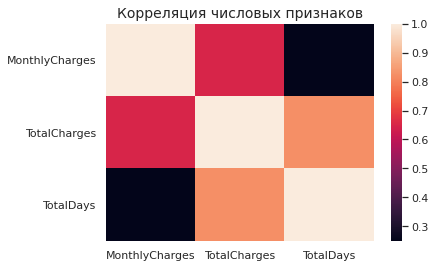

In [36]:
sns.set(font_scale=1)
sns.heatmap(df_churn[numeric_columns].corr())
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Видно, что сильная корреляция наблюдается между признакаями TotalDays и TotalCharges. Monthlycharges и TotalCharges скоррелированы довольно средне. Посмотрим внимательнее на диаграммы рассеяния.

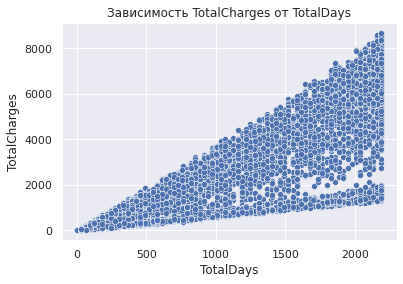

In [37]:
sns.scatterplot(data=df_churn, x="TotalDays", y="TotalCharges")
plt.title('Зависимость TotalCharges от TotalDays')
plt.show()

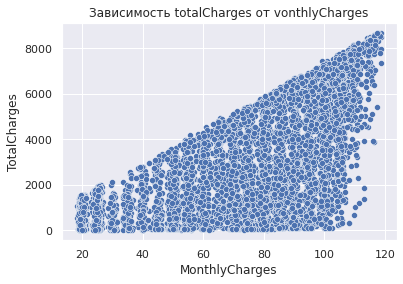

In [38]:
sns.scatterplot(data=df_churn, x="MonthlyCharges", y="TotalCharges")
plt.title('Зависимость totalCharges от vonthlyCharges')
plt.show()

Наблюдается довольно сильная линейная завивимость TotalCharges от TotalDays. Можно удалить признак TotalCharges, чтобы он не мешал модели.


**Выводы**:
* Значения в столбце `TotalCharges` убывают, в то же время в столбце `MonthlyCharges` виден пик в райне 85 - это значит, что пользователи, которые платят за тариф много на долго не остаются 
* Также у `MonthlyCharges` виден пик в районе 20, что является минимальным значением
* В столбце `TotalDays` видно 2 пика - в районе новых клиентов и лояльных, которые долго пользуются услугами 
* Аномальных выбросов не видно

**Общие Выводы**:
Удалим следующие признаки из датафрейма:
- customerID - уникальный идентификатор пользователя, "шум" для модели;

- TotalCharges - удаляем ввиду сильной корреляции с количеством месяцев пользования услугами;

- BeginDate - удаляем как фактор времени и чтобы избежать утечку данных ;

- EndDate - удаляем как фактор времени ;

- gender -  после проверки гипотезы о статистической значимости.


In [39]:
df_churn = df_churn.drop(['customerID', 'TotalCharges', 'BeginDate','EndDate','gender'], axis=1)

In [40]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Churn             7043 non-null   int64  
 5   TotalDays         7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   float64
 11  OnlineBackup      7043 non-null   float64
 12  DeviceProtection  7043 non-null   float64
 13  TechSupport       7043 non-null   float64
 14  StreamingTV       7043 non-null   float64
 15  StreamingMovies   7043 non-null   float64
 16  MultipleLines     7043 non-null   float64


Осталось 16 признаков и один целевой признак. Теперь займемся подготовкой признаков для моделей.

## Подготовка к обучению моделей

Будем использовать следующие модели: LogisticRegression, RandomForestClassifier и LGBMClassifier. Для логистической регрессии и случайного леса подготовим признаки с помощью OHE.

In [41]:
df_ohe = pd.get_dummies(df_churn, drop_first=True)
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       7043 non-null   int64  
 1   MonthlyCharges                         7043 non-null   float64
 2   Churn                                  7043 non-null   int64  
 3   TotalDays                              7043 non-null   int64  
 4   SeniorCitizen                          7043 non-null   int64  
 5   Partner                                7043 non-null   int64  
 6   Dependents                             7043 non-null   int64  
 7   OnlineSecurity                         7043 non-null   float64
 8   OnlineBackup                           7043 non-null   float64
 9   DeviceProtection                       7043 non-null   float64
 10  TechSupport                            7043 non-null   float64
 11  Stre

Выделим признаки и целевой признак.

In [42]:
target = df_ohe['Churn']
features = df_ohe.drop('Churn', axis=1)

Разобьем датасет на обучающую и тестовую выборку.

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

Проведем масштабирование количественных признаков

In [44]:
numeric = ['MonthlyCharges', 'TotalDays']
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train = features_train.copy()
features_train[numeric] = scaler.transform(features_train[numeric])

features_test = features_test.copy()
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,PaperlessBilling,MonthlyCharges,TotalDays,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic
2142,0,-0.000474,-0.464150,0,0,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0,1,1,0
1623,1,1.074754,0.886385,0,0,0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0,0,0,1
6074,1,-1.376499,-1.286039,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0
1362,1,0.177346,-1.160940,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1
6754,1,-0.098524,-1.326394,0,0,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,1,0,0,0,1,0


 Проверим баланс классов

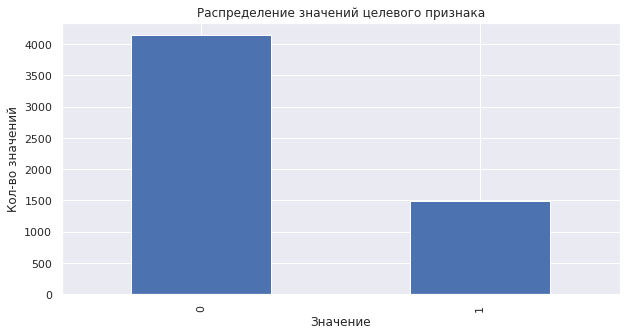

In [45]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

In [46]:
ratio = target_train[target_train == 1].count() / target_train[target_train == 0].count()
print(ratio)

0.36152730787820203


Видно, что присутсвует дисбаланс классов, надо будет провести upsampling, т.е увеличить число объектов меньшего класса путём их многократного копирования. Прт анализе зададим его в параметрах модели
в окончательной стадии.

In [47]:
#features_train, target_train = upsample(features_train, target_train, 3)

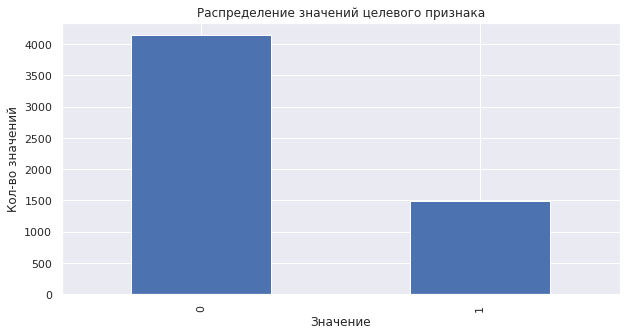

In [48]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

#Видно, что распределение значений целевого признака выровнялось

Теперь подготовим признаки для LGBMClassifier. Для этой модели кодирование не требуется, но необходимо перевести тип категориальных признаков в category.

In [49]:
columns_cat = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Dependents', 'SeniorCitizen',
           'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in columns_cat:
    df_churn[col] = df_churn[col].astype('category')

df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   Churn             7043 non-null   int64   
 5   TotalDays         7043 non-null   int64   
 6   SeniorCitizen     7043 non-null   category
 7   Partner           7043 non-null   category
 8   Dependents        7043 non-null   category
 9   InternetService   7043 non-null   category
 10  OnlineSecurity    7043 non-null   category
 11  OnlineBackup      7043 non-null   category
 12  DeviceProtection  7043 non-null   category
 13  TechSupport       7043 non-null   category
 14  StreamingTV       7043 non-null   category
 15  StreamingMovies   7043 non-null   category
 16  MultipleLines     7043 n

Так же произведем разделение на обучающую и тестовую выборку.

In [50]:
target_boost = df_churn['Churn']
features_boost = df_churn.drop('Churn', axis=1)

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
                                      features_boost, target_boost, test_size=0.2, random_state = RANDOM_STATE,
                                               shuffle=True,
                                               stratify=target_boost)

print('Размер таблицы признаков обучающей выборки: ', features_train_boost.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_boost.shape)

Размер таблицы признаков обучающей выборки:  (5634, 16)
Размер таблицы признаков тестовой выборки:  (1409, 16)


Заказчику важна метрика ROC-AUC, дополнительно Accuracy. Кроме того, важными параметрами являются время обучения и время предсказания модели.  
В целях автоматизации создадим функцию model_final, принимающую на вход модель, ее обучающие и тестовые параметры, и выдающую нам требуемые метрики, а также время обучения и время предсказания модели.

In [51]:
def model_final(model, X_train, y_train, X_test, y_test):
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start
    
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return train_time, predict_time, roc_auc, accuracy, precision, recall

## Обучение и тестирование моделей

Подберем оптимальные гиперпараметры для моделей, обучим на обучающей выборке и посчитаем метрики на тестовой

### LogisticRegression

In [52]:
model_regress = LogisticRegression(solver = 'liblinear')

penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 50)
class_weight = [None, 'balanced']

hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight)

rs_regress = RandomizedSearchCV(model_regress, 
                                hyperparameters, 
                                cv = 5,
                                n_iter = 10,
                                random_state = 0,
                                verbose = 0, 
                                n_jobs = 1, 
                                scoring = 'roc_auc')

train_time_regress, predict_time_regress, roc_auc_regress, accuracy_regress, precision_regress, recall_regress = model_final(rs_regress,
                                                                                          features_train,
                                                                                          target_train,
                                                                                          features_test,
                                                                                          target_test)


print('LogisticRegression:')
print('Время обучения: ', round(train_time_regress, 2), 'сек')
print('Время предсказания: ', round(predict_time_regress, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_regress, 2))
print('Accuracy модели: ', round(accuracy_regress, 2))
print('Precision модели: ', round(precision_regress, 2))
print('Recall модели: ', round(recall_regress, 2))

LogisticRegression:
Время обучения:  7.93 сек
Время предсказания:  0.01 сек
ROC-AUC модели:  0.86
Accuracy модели:  0.82
Precision модели:  0.69
Recall модели:  0.58


### RandomForestClassifier

In [53]:
model_forest = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50, num = 10)]
criterion = ['gini', 'entropy']
class_weight = [None, 'balanced']

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

rs_forest = RandomizedSearchCV(model_forest,
                               param_dist,
                               cv = 5,
                               n_iter = 10,
                               random_state = 0,
                               verbose = 0, 
                               n_jobs= 1, 
                               scoring = 'roc_auc')

train_time_forest, predict_time_forest, roc_auc_forest, accuracy_forest, precision_forest, recall_forest = model_final(rs_forest, features_train, target_train,
                                                           features_test, target_test)

print('RandomForestClassifier:')
print('Время обучения: ', round(train_time_forest, 2), 'сек')
print('Время предсказания: ', round(predict_time_forest, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_forest, 2))
print('Accuracy модели: ', round(accuracy_forest, 2))
print('Precision модели: ', round(precision_forest, 2))
print('Recall модели: ', round(recall_forest, 2))

RandomForestClassifier:
Время обучения:  3.43 сек
Время предсказания:  0.01 сек
ROC-AUC модели:  0.87
Accuracy модели:  0.81
Precision модели:  0.7
Recall модели:  0.51


### LGBMClassifier

In [54]:
model = LGBMClassifier(objective='binary', metric='auc')

search_space_lgbm = [{'learning_rate': [0.0005, 0.001, 0.01, 0.05, 0.1],
                       'n_estimators': [100, 200, 300, 500],
                       'num_leaves': [10, 20, 30, 50, 70, 100, 150],
                     'class_weight': [None, 'balanced']}]


rs_lgbm = RandomizedSearchCV(model, 
                        search_space_lgbm, 
                        cv = 5, 
                        n_iter=5,
                        random_state=0,
                        verbose = 0, 
                        n_jobs=1,
                        scoring={'AUC':'roc_auc'},
                        refit='AUC')

train_time_lgbm, predict_time_lgbm, roc_auc_lgbm, accuracy_lgbm, precision_lgbm, recall_lgbm = model_final(rs_lgbm, features_train_boost,
                                                                                          target_train_boost,
                                                                                          features_test_boost,
                                                                                          target_test_boost)

print('LGBMClassifier:')
print('Время обучения: ', round(train_time_lgbm, 2), 'сек')
print('Время предсказания: ', round(predict_time_lgbm, 2), 'сек')
print('ROC-AUC модели: ', round(roc_auc_lgbm, 2))
print('Accuracy модели: ', round(accuracy_lgbm, 2))
print('Precision модели: ', round(precision_lgbm, 2))
print('Recall модели: ', round(recall_lgbm, 2))

LGBMClassifier:
Время обучения:  1376.03 сек
Время предсказания:  0.2 сек
ROC-AUC модели:  0.9
Accuracy модели:  0.85
Precision модели:  0.73
Recall модели:  0.68


Для лучшей модели (LGBMClassifier) построим график важности признаков (feature importances).

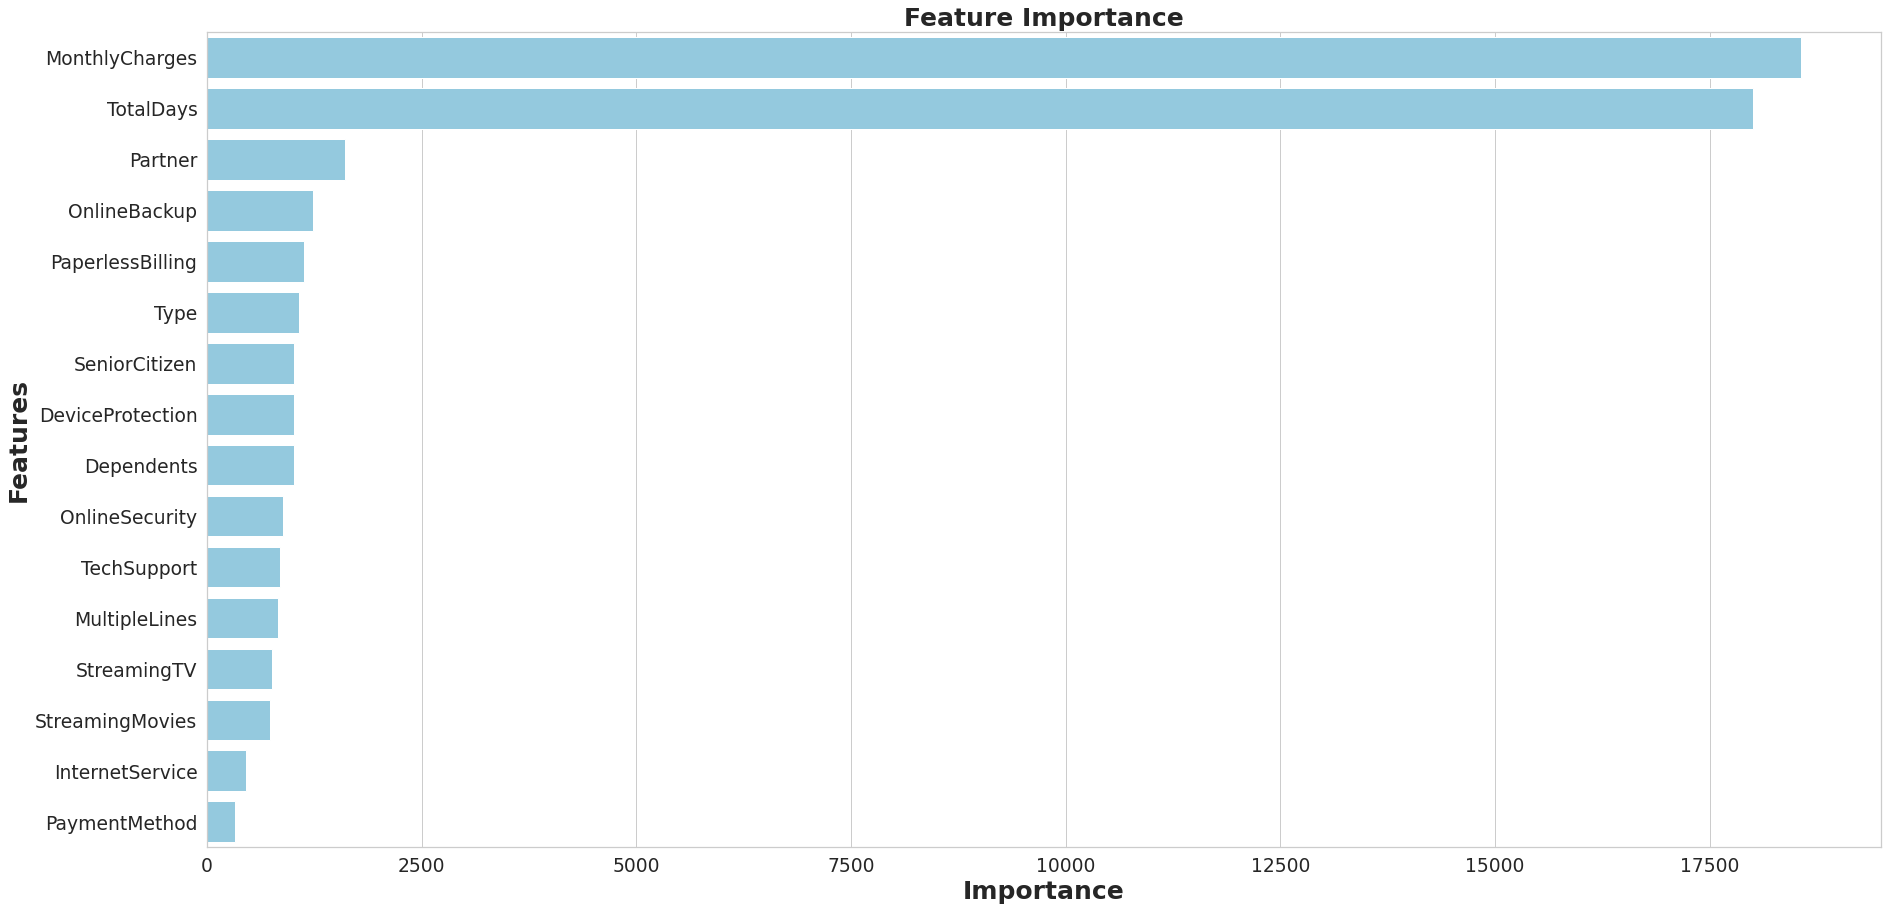

In [55]:
top_params = rs_lgbm.best_params_
model_lgbm = LGBMClassifier(learning_rate = top_params['learning_rate'],
                                     n_estimators = top_params['n_estimators'],
                                     num_leaves = top_params['num_leaves'],
                                     class_weight = top_params['class_weight'],
                                     objective='binary',
                                     metric='AUC')

model_lgbm.fit(features_train_boost, target_train_boost)

feats = {}
for feature, importance in zip(features_boost.columns, model_lgbm.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

Видим, что наиболее важные признаки - ежемесячная плата за услуги и "время жизни" клиента. 
Проведем анализ всех моделей.

## Анализ моделей

Построим ROC-кривые для всех трех моделей.

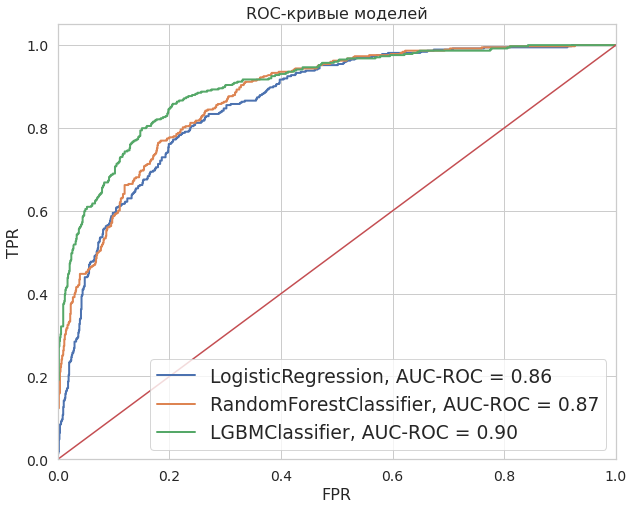

In [56]:
fpr1, tpr1, thresholds1 = roc_curve(target_test, rs_regress.predict_proba(features_test)[:,1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(target_test, rs_forest.predict_proba(features_test)[:,1], pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(target_test_boost, rs_lgbm.predict_proba(features_test_boost)[:,1],
                                                                                           pos_label=1)

auc_regress = roc_auc_score(target_test, rs_regress.predict_proba(features_test)[:,1])
auc_forest = roc_auc_score(target_test, rs_forest.predict_proba(features_test)[:,1])
auc_lgbm = roc_auc_score(target_test_boost, rs_lgbm.predict_proba(features_test_boost)[:,1])

lw=2
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr1, tpr1, lw=lw, label= 'LogisticRegression, AUC-ROC = %.2f' %auc_regress)
ax.plot(fpr2, tpr2, lw=lw, label= 'RandomForestClassifier, AUC-ROC = %.2f' %auc_forest)
ax.plot(fpr3, tpr3, lw=lw, label= 'LGBMClassifier, AUC-ROC = %.2f' %auc_lgbm)

plt.title('ROC-кривые моделей', fontsize=16)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1])
plt.xlim([0.0, 1.0])
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.ylim([0.0, 1.05])
plt.tick_params(which='major', labelsize=14)
plt.show()

По метрике AUC-ROC уверенно лидирует все-таки LGBMClassifi. Nак как наш датасет несбалансирован, метрика Accuracy не показательна. Важно посмотреть на матрицу ошибок.

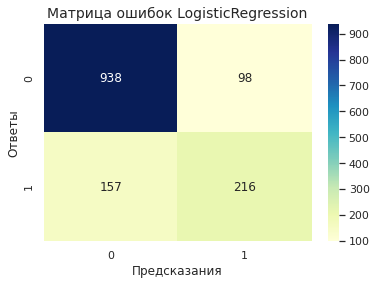

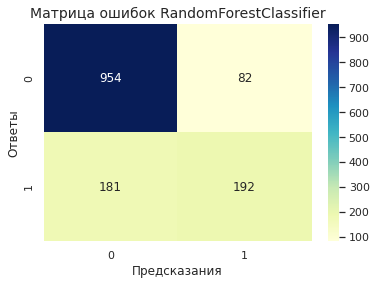

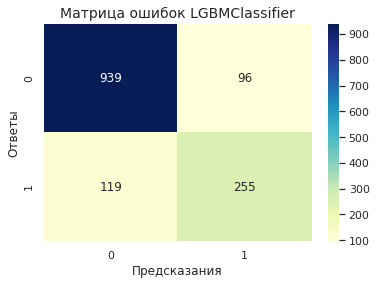

In [57]:
df_cm_regress = pd.DataFrame(confusion_matrix(target_test, rs_regress.predict(features_test)))
df_cm_forest = pd.DataFrame(confusion_matrix(target_test, rs_forest.predict(features_test)))
df_cm_lgbm = pd.DataFrame(confusion_matrix(target_test_boost, rs_lgbm.predict(features_test_boost)))

df_list = [df_cm_regress, df_cm_forest, df_cm_lgbm]
df_list_name = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']
sns.set(font_scale=1)

for df, df_name in zip(df_list, df_list_name):
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
    plt.title('Матрица ошибок ' + df_name, fontsize=14)
    plt.xlabel('Предсказания', fontsize=12)
    plt.ylabel('Ответы', fontsize=12)
    plt.show()

По итогам обучения моделей можно сказать следующее:

* LogisticRegression хуже других справляется с задачей. AUC-ROC неплохой (0.85), но точность и полнота хуже. На матрице ошибок видно, что модель уходит в False Positive, а значит модель ошибочно считает ушедшими лоялбных клиентов;

* RandomForestClassifier работает почти так же, как и регрессия, AUC-ROC равен 0.86, точность немного выше, полнота такая же. Модель также переусердствует в присвоении False Positive.

* LGBMClassifier показывет хорошую метрику (0.9). Полнота и accuracy самые высокие. Модель намного точнее предсказывает действительно уходящих клиентов. И что самое хорошее - выдает наибольшое True Positive то есть верно определяя лояльных клиентов,при этом не переприсваивая False Positive.

Построим сводную таблицу метрик и времени:

In [58]:
data = {'AUC-ROC':[roc_auc_regress, roc_auc_forest, roc_auc_lgbm],
        'Accuracy':[accuracy_regress, accuracy_forest, accuracy_lgbm],
        'Precision':[precision_regress, precision_forest, precision_lgbm],
        'Recall':[recall_regress, recall_forest, recall_lgbm],
       'Train time, сек':[train_time_regress, train_time_forest, train_time_lgbm],
       'Predict time, сек':[predict_time_regress, predict_time_forest, predict_time_lgbm]}

table_compare = pd.DataFrame(data)
pd.set_option('display.float_format', '{:.2f}'.format)
table_compare.index = ['LogisticRegression', 'RandomForestClassifer', 'LGBMCLassifier']
display(table_compare)

,AUC-ROC,Accuracy,Precision,Recall,"Train time, сек","Predict time, сек"
LogisticRegression,0.86,0.82,0.69,0.58,7.93,0.01
RandomForestClassifer,0.87,0.81,0.70,0.51,3.43,0.01
LGBMCLassifier,0.90,0.85,0.73,0.68,1376.03,0.20


 Лучшая модель по совокупности всех метрик - LGBMCLassifier. Но у нее есть свои недостатки: склонность к переобучению и самое долгое время обучения из рассматриваемых.


## Общий вывод и рекомендации заказчику

Телеком компания предоставила данные в 4 файлах. Необходимо было обучить модель, которая предсказывала бы отток клиентов. Целевая метрика - ROC-AUC не ниже 0.88.  
Сначала данные были прочитаны и по ним были сделаны предварительные выводы.  
После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы  данных.  
Были добавлены 2 новых столбца - целевой признак Churn, который означает отказался ли клиент от услуг и TotalDays, который обозначает сколько по времени пользователь пользовался услугами.  
После этого был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком.  
Были сделаны следующие выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше , большинство ушедших клиентов были подключены по оптоволокну.  
После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков.  
На этом этапе было решено не изпользовать функцию для upsample , так как хотя требуемые от нас метрики менялись незначительно, разница в precision и recall быда заметно ( а это тоже может сэкономить деньги бизнесу). Кроме того были удалены фичи связаные с датами, которые "зашумляют" модель. Также при анализе важности признаков видно что основных признаков для обучения модели всего два, что можно использовать в дальнейшем отсекая лишние фичи, чтобы ускорить время обучения модели.  

В целом, можно рекомендовать заказчику две модели: LGBMClassifier и RandomForestClassifier. Первая отличная по метрикам, но долгая по времени обучения, плюс нужно контролировать переобучение. Вторая хуже по метрикам, но обучается очень быстро и к переобучению не склонна. 

| модель | AUC-ROC | Accuracy | Precision | Recall | Train time, сек |   
|:------|:----------:|:------------:|:--------:|:--------:|:--------:|  
| RandomForestClassifer | 0.87 | 0.81 | 0.7 | 0.51 | 3.43 |  
| **LGBMCLassifier** | **0.90** | 0.85 | 0.73 | 0.68 | 1376.03 |  

  

При выборе модели заказчику нужно соблюсти баланс между минимальным FP (чтобы не потратить бюджет на клиентов, которые не собирались уходить), FN (чтобы не упустить действительно уходящих), а также временем обучения модели.

Что касается рекомендаций непосредственно по бизнесу,  основная масса клиентов уходит из-за высоких тарифов на интернет по оптоволокну. Это действительно дорого (75-100 у.е.), при том что среди оставшихся клиентов преобладают клиенты с ежемесячной платой 20 у.е. Такую сумму готов платить средний клиент. Также компании следует задуматься о специальных предложениях для новых клиентов (акционные тарифы), так как основная масса ушедших клиентов пришла в компанию в 2019 году. Вообще с каждым годом наблюдается тенденция к оттоку именно новых клиентов. А это значит, что у других провайдеров предложения для новых клиентов выгоднее.